Visualize pretrained graph embeddings

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data, DataLoader, DenseDataLoader as DenseLoader
from torch_geometric.data import InMemoryDataset
import torch_geometric.transforms as T
from diff_pool6_max import DiffPool as DiffPool
from scipy.spatial.distance import pdist

In [2]:
"""
load dataset 
"""

with open(r'./data/patient_gumbel4.pickle', 'rb') as handle:
    patient_dict = pickle.load(handle)
        
class PatientDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(PatientDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['patient.dataset']

    def download(self):
        pass
    
    def process(self):
        
        data_list = []
        node_labels_dict = {'CD3p': 0, 'CD3p_CD4p': 1, 'CD8p_CD3p': 2, 'Tumor': 3, 'Stroma': 4}
        class_num = len(node_labels_dict)
        
        for idx, v in enumerate(patient_dict.values()):
            for G in v:
                node_features = torch.LongTensor([node_labels_dict[i] for i in 
                                list(nx.get_node_attributes(G, 'cell_types').values())]).unsqueeze(1)
                x = torch.zeros(len(G.nodes), class_num).scatter_(1, node_features, 1)
                y = torch.LongTensor([idx])
                edges = sorted([e for e in G.edges] + [e[::-1] for e in G.edges])
                edge_index = torch.tensor([[e[0] for e in edges],
                                           [e[1] for e in edges]], dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        
def get_dataset(path, sparse=False):
    
    dataset = PatientDataset(path)
    if not sparse:
        max_num_nodes = 0
        for data in dataset:
            max_num_nodes = max(data.num_nodes, max_num_nodes)

        if dataset.transform is None:
            dataset.transform = T.ToDense(max_num_nodes)
        else:
            dataset.transform = T.Compose(
                [dataset.transform, T.ToDense(max_num_nodes)])

    return dataset

dataset_dict = {}
path = './data/patient_gumbel4'
dataset_dict['gumbel2_5'] = get_dataset(path, sparse=False)

In [3]:
# save on gpu, load on cpu
# load model parameters 
def load_model(dir_path, params_name, m, num_patches=5, ratio=0.05, dropout=False, plot=True, ge=False):
    device = torch.device('cpu')
    model = m(dataset_dict['gumbel2_5'], 5, 64, num_patches=num_patches, ratio=ratio, dropout=dropout, plot=plot, ge=ge)
    params = torch.load(dir_path+params_name, map_location=device)
    model.load_state_dict(params)
    return model

# generate graph embeddings
def generate_graph_embedding(model, loader):
    model.eval()
    
    output = []
    for data in data_loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
            output.append(out.numpy())
    output = np.concatenate(output)
    
    return output

In [4]:
# data loader
batch_size = 50
data_loader = DenseLoader(dataset_dict['gumbel2_5'], batch_size, shuffle=False)


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dir_path = './data/DiffPool_diff_pool6_max_bs50/gumbel2_5/'
params_name = 'params_epoch140.pt'
model = load_model(dir_path, params_name, DiffPool, ratio=0.05, \
                   plot=False, ge=True)
output = generate_graph_embedding(model, data_loader)

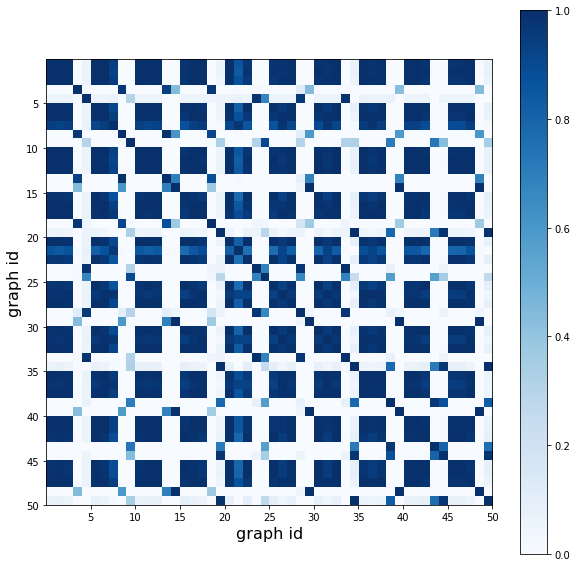

In [6]:
fig = plt.figure(figsize=(10, 10))
cosine_matrix = cosine_similarity(output)
plt.imshow(cosine_matrix, cmap=cm.Blues, extent=[0, 50, 50, 0])
plt.xticks([i for i in range(5, 51, 5)])
plt.yticks([i for i in range(5, 51, 5)])
plt.xlabel('graph id', fontsize=16)
plt.ylabel('graph id', fontsize=16)
plt.colorbar()
plt.show()

In [7]:
f1_x = lambda x: x*5+3
f2_x = lambda x: x*5+4
keep_indices = [f(i) for i in range(10) for f in (f1_x, f2_x)]
discard_indices = list(set([i for i in range(50)]) - set(keep_indices)) 
print('Average distance of all graphs: {}\n' \
      'Average distance of distinctive graphs: {}\n' \
      'Average distance of similar graphs: {}\n'.format(pdist(output).mean(), \
                                                        pdist(output[keep_indices]).mean(), \
                                                        pdist(output[discard_indices]).mean()))

Average distance of all graphs: 12.040071417797236
Average distance of distinctive graphs: 14.679801309642942
Average distance of similar graphs: 2.290810291242748

